# Bayesian Parameter Estimation

In [1]:
import os
import glob
import pickle

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd
import emcee
import numba

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

# Set the plotting style.
import sys
sys.path.insert(0, '../')
import mwc_mutants_utils as mwc
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

#### $\LaTeX$ command definitions.
$\newcommand \foldchange{\operatorname{fold-change}}$

# Bayesian parameter estimation

In this notebook we will explore the problem of inferring the parameters related to the protein structure using Markov-Chain Monte Carlo (MCMC) to sample out of the posterior distribution of these parameters given the data.

First we know that the theoretical prediction for the fold-change in gene expression due to the presence of the transcriptional repressor for our simple repression architecture is given by
$$
\text{fold-change} = \frac{1}{1 + p_{act}(c) \frac{R}{N_{NS}}  e^{-\beta \Delta \varepsilon_{RA}}},
\tag{1}
$$

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific binding sites, $\Delta \varepsilon_{RA}$ is the repressor binding energy to the DNA, and $p_{act}(c)$, the probability of the repressor being in the active state as a function of the ligand concentration $c$ is given by
\begin{equation}
p_{act}(c) = \frac{\left( 1 + \frac{c}{c_o} e^{\tilde{k}_A}\right)^2}{\left( 1 + \frac{c}{c_o} e^{\tilde{k}_A}\right)^2 + e^{-\beta \Delta\varepsilon_{AI}} \left( 1 + \frac{c}{c_o} e^{\tilde{k}_I}\right)^2},
\tag{2}
\end{equation}
where $\Delta\varepsilon_{AI}$ is the energy difference between the active and the inactive state of the repressor, and $c_o$ is a reference concentration taken up to be 1 $M$. Both mathematically and numerically, it is convenient to define $\tilde{k}_A = -\log \frac{K_A}{c_o}$ and $\tilde{k}_I = -\log \frac{K_I}{c_o}$ and fit for these parameters on a log scale. Dissociation constants are scale invariant, so that a change from $10\,\mu\text{M}$ to $1\,\mu\text{M}$ leads to an equivalent increase in affinity as a change from $1\,\mu\text{M}$ to
$0.1\,\mu\text{M}$

If we want to infer 3 parameters out of Eq. 1 and 2 related to the protein structure, i.e. $\Delta\varepsilon_{RA}$, $\tilde{k}_A$, and $\tilde{k}_I$ we can write the probability distribution of the parameter values given the data $D$. This distribution is given by Bayes theorem as
\begin{equation}
	P(\Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I \mid D) = \frac{P(D \mid \Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)P(\Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)}{P(D)},
\tag{3}
\end{equation}
where $D$ is composed by all the independent variables (repressor copy
number $R$, and inducer concentration $c$) and one dependent variable (experimental fold-change). $P(D \mid \Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)$ is the likelihood of having observed the data given the parameter values, $P(\Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I)$ contains all the prior information on these parameters, and $P(D)$ serves as a normalization constant, which we can ignore in our parameter estimation. Eq. 1 and 2 assume a deterministic relationship between the parameters and the data, so in order to construct a probabilistic relationship as required by Eq. 3, we assume that the experimental fold-change for the $i^\text{th}$ datum given the parameters is of the form
\begin{equation}
\text{fold-change}_{\exp}^{(i)} = \left( 1 + \frac{\left(1 +
\frac{c^{(i)}}{c_o}e^{\tilde{k}_A}\right)^2}{\left( 1 + \frac{c^{(i)}}{c_o}e^{\tilde{k}_A}\right)^2 +
e^{-\beta \Delta \varepsilon_{AI}} \left(1 +  \frac{c^{(i)}}{c_o}e^{\tilde{k}_I} \right)^2} \frac{R^{(i)}}{N_{NS}} e^{-\beta
\Delta \varepsilon_{RA}}\right)^{-1} + \epsilon^{(i)},
\tag{4}
\end{equation}
where $\epsilon^{(i)}$ represents the departure from the deterministic
theoretical prediction for the $i^\text{th}$ data point. If we assume that these
$\epsilon^{(i)}$ errors are normally distributed with mean zero and standard
deviation $\sigma$, the likelihood of the data given the parameters is of the
form
\begin{equation}
P(D \mid \Delta\varepsilon_{RA}, \tilde{k}_A, \tilde{k}_I, \sigma) =
\frac{1}{(2\pi\sigma^2)^{\frac{n}{2}}}\prod\limits_{i=1}^n \exp
\left[-\frac{(\foldchange^{(i)}_{\exp} - \foldchange(\tilde{k}_A, \tilde{k}_I, R^{(i)},
\Delta\varepsilon_{RA}^{(i)}, \frac{c^{(i)}}{c_o}))^2}{2\sigma^2}\right],
\tag{5}
\end{equation}
where $\foldchange^{(i)}_{\text{exp}}$ is the experimental fold-change and
$\foldchange(\,\cdots)$ is the theoretical prediction. The product $\prod_{i=1}^n$
captures the assumption that the $n$ data points are independent. Note that the
likelihood and prior terms now includes the extra unknown parameter $\sigma$. In
applying Eq. 5, a choice of $\tilde{k}_A$ and $\tilde{k}_I$ that provides better
agreement between theoretical fold-change predictions and experimental
measurements will result in a higher value likelihood value.

In addition, we assume a uniform distribution for $\tilde{k}_A$ and
$\tilde{k}_I$ and a Jeffreys prior for the scale parameter $\sigma$. This yields the complete prior
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, \sigma) \equiv \frac{1}{(\tilde{k}_A^{\max} -
\tilde{k}_A^{\min})} \frac{1}{(\tilde{k}_I^{\max} -
\tilde{k}_I^{\min})}\frac{1}{\sigma}.
\tag{6}
\end{equation}

These priors are maximally uninformative meaning that they imply no prior knowledge of the parameter values.

### The MCMC approach to the problem.

We will now use MCMC to sample out of this distribution to fit for the 3 parameters. For this we need to define functions to compute the log probability.

In [3]:
@numba.jit(nopython=True)
def pact_jit(iptg, ka, ki, epsilon=4.5, n=2):
    '''
    Returns the probability of a repressor bking active as described
    by the MWC model.

    Parameter
    ---------
    iptg : array-like.
        Concentrations of inducer on which to evaluate the function.
        All values must be positive.
    ka, ki : float.
        Minus log of the dissociation constants of the active and the
        inactive states respectively.
    epsilon : float.
        Positive log of the energy difference between the active and the
        inactive state.
    n : int
        Number of inducer binding sites.
    Returns
    -------
    pact : float.
        probability of a repressor of bking in the active state.
        Active state is defined as the state that can bind to the DNA.
    '''
    return (1 + iptg * np.exp(ka))**n / ((1 + iptg * np.exp(ka))**n +
                                         np.exp(-epsilon) *
                                         (1 + iptg * np.exp(ki))**n)

@numba.jit(nopython=True)
def fold_change_jit(iptg, ka, ki, epsilon, R, epsilon_r, n=2,
                    quaternary_state=1, nonspec_sites=4.6E6):
    '''
    Returns the gene expression fold change according to the
    thermodynamic model with the extension that takes into account the
    effect of the inducer.

    Parameter
    ---------
    iptg : array-like.
        Concentrations of inducer on which to evaluate the function
    ka, ki : float.
        Minus log of the dissociation constants of the active and the
        inactive states respectively
    epsilon : float.
        Energy difference between the active and the inactive state
    R : array-like.
        Repressor copy number for kach of the strains. The length of
        this array should be equal to the iptg array. If only one value
        of the repressor is given it is asssume that all the data points
        should be evaluated with the same repressor copy number
    epsilon_r : array-like
        Repressor binding energy. The length of this array
        should be equal to the iptg array. If only one value of the
        binding energy is given it is asssume that all the data points
        should be evaluated with the same repressor copy number
    quaternary_state: int
        Prefactor in front of R in fold-change. Default is 2
        indicating that there are two functional hkads per repressor molecule.
        This value must not be zero.
    nonspec_sites : int
        Number of nonspecific binding sites in the system.
        This value must be grkater than 0.

    Returns
    -------
    fold_change : float.
        Gene expression fold change as dictated by the thermodynamic model.
    '''
    return (1 + quaternary_state * R / nonspec_sites *
            pact_jit(iptg, ka, ki, epsilon, n) * (1 + np.exp(-epsilon)) *
            np.exp(-epsilon_r))**-1

In [4]:
@numba.jit(nopython=True)
def log_likelihood(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 4
        with the following entries
        param[0] = epsilon_r
        param[1] = ka == -lnKa
        param[2] = ki == -lnKi
        param[3] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 2 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    epsilon_r, ka, ki, sigma = param
    
    # unpack independent variables
    IPTG, R = indep_var[:, 0], indep_var[:, 1]
    
    # compute the theoretical fold-change
    fc_theory = fold_change_jit(IPTG, ka, ki, epsilon, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
@numba.jit(nopython=True)
def log_post(param, indep_var, dep_var, epsilon=4.5,
             epsilon_r_range=[-20, 0], ka_range=[7, -7], ki_range=[7, -7]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 4
        with the following entries
        param[0] = epsilon_r
        param[1] = ka == -lnKa
        param[2] = ki == -lnKi
        param[3] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon_r_range : array-like.
        Range of variables to use in the prior as boundaries for the epsilon_r 
        parameter.
    ka_range : array-like.
        Range of variables to use in the prior as boundaries for the ka parameter.
    ki_range : array-like.
        Range of variables to use in the prior as boundaries for the ki parameter.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    epsilon_r, ka, ki, sigma = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if epsilon_r > np.max(epsilon_r_range)\
    or epsilon_r < np.min(epsilon_r_range)\
    or ka > np.max(ka_range) or ka < np.min(ka_range)\
    or ki > np.max(ki_range) or ki < np.min(ki_range)\
    or sigma <= 0:
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(sigma)\
    - log_likelihood(param, indep_var, dep_var, epsilon)

## Testing the functions

Having defined these functions let's estimate the parameters for one of the strains to make sure everything works.

Let's first read the data.

In [5]:
# Read the CSV file with the mean fold change
df = pd.read_csv('../../data/flow_master.csv',index_col=0 , comment='#')
df = df[(df.strain!='auto') & (df.strain!='delta')]
df.head()

date  username operator class strain  repressors  IPTG_uM  \
24  20170303  mrazomej       O2   dna   Q21A         260      0.1   
25  20170303  mrazomej       O2   dna   Q21A         260      0.0   
26  20170303  mrazomej       O2   dna   Q21A         260   1000.0   
27  20170303  mrazomej       O2   dna   Q21A         260    100.0   
28  20170303  mrazomej       O2   dna   Q21A         260     10.0   

        mean_YFP  mean_YFP_bgcorr  fold_change  
24  10207.801372      6061.418830     0.219585  
25   9536.491380      5220.269553     0.278905  
26  20307.551849     16127.546380     0.970668  
27  19769.723730     15746.672950     0.913559  
28  10745.853106      6788.125747     0.369471

### Initializing walkers around the most likely parameters.

In order to speed up the burn in step we can initialize the walkers around the most likely parameters found via optimization. For this performs a non-linear regression to find the most likely parameters and then initialize the walkers around those parameter values.

We have defined a function that performs a non-linear regression in a single step, finding the most likely parameters directly. For more details on how this non-linear regression is performed please visit [this tutorial](https://rpgroup-pboc.github.io/mwc_induction/code/notebooks/SI_E_nonlinear_regression.html)

In [6]:
# Extract the data
df_example = df[(df.operator=='O2') & (df.strain=='Q21A')]

# Define the independent variables
indep_var = df_example[['IPTG_uM', 'repressors']].values
dep_var = df_example.fold_change.values

# Initial guess
p0 = np.array([-10, -np.log(139.59), -np.log(0.53)])

# Peroform non-linear regression to obtain MAP and covariance matrix
map_param, cov = mwc.non_lin_reg(p0, indep_var, dep_var)

Let's now initialize the walkers for the MCMC run.

In [7]:
#Define the parameters for emcee
n_dim = 4 # number of parameters to fit

n_walkers = 50
n_burn = 250
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1, 2]] = np.random.multivariate_normal(map_param, cov, n_walkers)
p0[:, 3] = np.random.uniform(1E-5, 0.2, n_walkers)

# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
            args=(indep_var, dep_var, 4.5, 
                  np.array([-20, 0]), np.array([7, -7]), np.array([7, -7])))

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: covariance is not positive-semidefinite.


And now we run the MCMC.

In [8]:
sample = False
if sample:
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    filename = '{0:s}_{1:.0f}_{2:s}.pkl'.format(df_example.operator.unique()[0],
                                        df_example.repressors.unique()[0],
                                        df_example.strain.unique()[0])
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + filename, 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

Let's look at the corner plot for all parameters we care about.

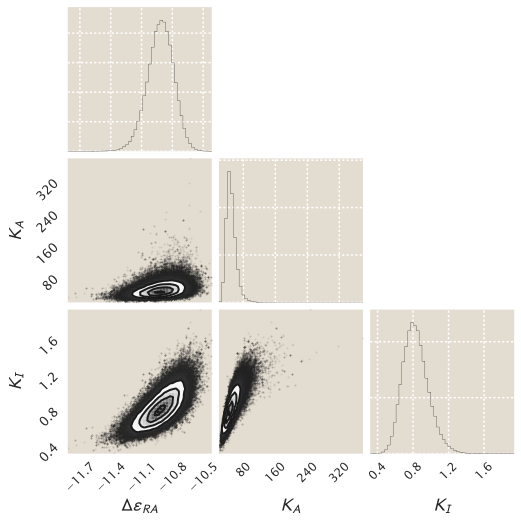

In [26]:
# Load the flat-chain
filename = '{0:s}_{1:.0f}_{2:s}.pkl'.format(df_example.operator.unique()[0],
                                        df_example.repressors.unique()[0],
                                        df_example.strain.unique()[0])
with open('../../data/mcmc/' + filename, 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()


# Draw the corner plot
chain = np.vstack([gauss_flatchain[:,0], np.exp(-gauss_flatchain[:,1]),
                   np.exp(-gauss_flatchain[:,2])]).T
fig = corner.corner(chain, bins=50, plot_contours=True,
                   labels=[r'$\Delta\varepsilon_{RA}$', r'$K_A$', 
                           r'$K_I$'])

Let's now convert the MCMC chain into a `pandas` dataframe.

In [28]:
# Load the flat-chain
filename = '{0:s}_{1:.0f}_{2:s}.pkl'.format(df_example.operator.unique()[0],
                                        df_example.repressors.unique()[0],
                                        df_example.strain.unique()[0])
with open('../../data/mcmc/' + filename, 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['epsilon_r', 'ka', 'ki', 'sigma']

# Generate a data frame out of the MCMC chains
mcmc_rbs = pd.DataFrame(gauss_flatchain, columns=index)
mcmc_rbs['Ka'] = np.exp(-mcmc_rbs['ka'])
mcmc_rbs['Ki'] = np.exp(-mcmc_rbs['ki'])

# rerbsine the index with the new entries
index = mcmc_rbs.columns
mcmc_rbs.head()

epsilon_r        ka        ki     sigma         Ka        Ki
0 -10.778091 -4.033551 -0.001619  0.093182  56.461065  1.001620
1 -10.822480 -3.971040  0.070559  0.082279  53.039647  0.931872
2 -10.822480 -3.971040  0.070559  0.082279  53.039647  0.931872
3 -10.784851 -4.037591  0.015825  0.085819  56.689606  0.984300
4 -10.786778 -4.033192  0.018158  0.086266  56.440791  0.982006

In [31]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
epsilon_r, ka, ki, sigma, Ka, Ki = mcmc_rbs.ix[max_idx, :]

# ka range
epsilon_hpd = mwc.hpd(mcmc_rbs.ix[:, 0], 0.95)
Ka_hpd = mwc.hpd(mcmc_rbs.ix[:, 4], 0.95)
Ki_hpd = mwc.hpd(mcmc_rbs.ix[:, 5], 0.95)

# Print results
print("""
The most probable parameters for the model
------------------------------------------
epsilon_RA = {0:.2f} -{1:0.2f} +{2:0.2f} kBT
Ka = {3:.2f} -{4:0.2f} +{5:0.2f} µM
Ki = {6:.2f} -{7:0.3f} +{8:0.3f} µM
""".format(epsilon_r, np.abs(epsilon_r-epsilon_hpd[0]),\
           np.abs(epsilon_r-epsilon_hpd[1]),\
           Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the model
------------------------------------------
epsilon_RA = -10.91 -0.26 +0.24 kBT
Ka = 45.93 -16.85 +27.97 µM
Ki = 0.81 -0.249 +0.314 µM



# Systematically perform the MCMC for all strains

Now that we have all the infrastructure let's perform the MCMC for all the strains, including the WT.

In [35]:
# Group data frame by operator and strain
df_group = df.groupby(['operator', 'repressors', 'strain'])

# Define the parameters for emcee
n_dim = 4 # number of parameters to fit
n_walkers = 50
n_burn = 250
n_steps = 5000

run_mcmc = True
if run_mcmc:
    for group, data in df_group:
        print(group)
        # Determine the name of the MCMC chain
        filename = '{0:s}_{1:.0f}_{2:s}.pkl'.format(group[0], group[1], group[2])
        # Initialize walkers
        p0 = np.empty((n_walkers, n_dim))
        p0[:,[0, 1, 2]] = np.random.multivariate_normal(map_param, cov, n_walkers)
        p0[:, 3] = np.random.uniform(1E-5, 0.2, n_walkers)
        # Call the sampler. 
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                    args=(indep_var, dep_var, 4.5,  np.array([-20, 0]), 
                          np.array([7, -7]), np.array([7, -7])))
        #Do the burn in 
        pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
        _ = sampler.run_mcmc(pos, n_steps)
        output = open('../../data/mcmc/' + filename, 'wb')
        pickle.dump(sampler.flatchain, output)
        pickle.dump(sampler.flatlnprobability, output)
        output.close() # close it to make sure it's all been written

('O1', 260, 'Q21A')


/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: covariance is not positive-semidefinite.


('O1', 260, 'Q21M')
('O1', 260, 'Y20I')
('O1', 260, 'wt')
('O2', 260, 'Q21A')
('O2', 260, 'Q21M')
('O2', 260, 'Y20I')
('O2', 260, 'wt')


# Plotting theory vs. data

In order to see how well the fit work let's plot the theory and the data for each of the strains. But first let's define a function to compute the credible region for the fold-change given the MCMC chains.

In [ ]:
def cred_region(IPTG, flatchain, R, epsilon_r, mass_frac=.95, epsilon=4.5):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        MCMC traces for the two MWC parameters.
        flatchain[:,0] = ~ka flat-chain
        flatchain[:,1] = ~ki flat-chain
    R : float.
        Mean repressor copy number.
    epsilon_r : float.
        Repressor binding energy.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = mwc.fold_change_log(c, flatchain[:,0], flatchain[:, 1], epsilon,
                                R, epsilon_r)
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    
    return cred_region

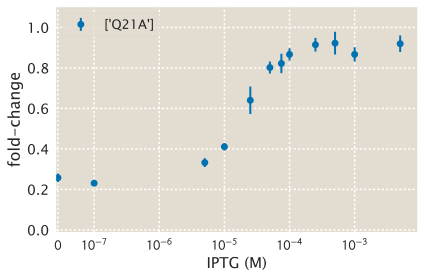

In [27]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

# Initialize the plot to set the size
fig, ax = plt.subplots(1, 1)
# compute the mean value for each concentration
fc_mean = df_example.groupby('IPTG_uM').fold_change.mean()
# compute the standard error of the mean
fc_err = df_example.groupby('IPTG_uM').fold_change.std() / \
np.sqrt(df_example.groupby('IPTG_uM').size())
ax.errorbar(np.sort(df_example.IPTG_uM.unique()) / 1E6,
        fc_mean, yerr=fc_err, fmt='o', 
        label= df_example.strain.unique(), zorder=100)

# Plot theoretical prediction
#### MODEL 1 ###
# Log scale
# ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
#     ea=ka, ei=ki, epsilon=4.5,
#     R=df_example.repressors.unique()[0],
#     epsilon_r=popt_1[0]),
#     color='black', label='model 1')
# # # Linear scale
# ax.plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
#     ea=ka, ei=ki, epsilon=4.5,
#     R=df_example.repressors.unique()[0],
#     epsilon_r=popt_1[0]),
#     linestyle='--', color='black', label=None)
# #### MODEL 2 ###
# # Log scale
# ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
#     ea=popt_2[1], ei=popt_2[2], epsilon=4.5,
#     R=df_example.repressors.unique()[0],
#     epsilon_r=popt_2[0]),
#     color='darkred', label='model 2')
# # # Linear scale
# ax.plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
#     ea=popt_2[1], ei=popt_2[2], epsilon=4.5,
#     R=df_example.repressors.unique()[0],
#     epsilon_r=popt_2[0]),
#     linestyle='--', color='darkred', label=None)

ax.set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
ax.set_xlabel('IPTG (M)', fontsize=15)
ax.set_ylabel('fold-change', fontsize=16)
ax.set_ylim([-0.01, 1.1])
ax.set_xlim(left=-5E-9)
ax.tick_params(labelsize=14)
ax.legend(loc='upper left')
plt.tight_layout()

Let's define a function that takes the `emcee` `flatchains` and computes the confidence interval.

In [5]:
def mcmc_cred_region(IPTG, flatchain, R, epsilon_r,
                     mass_frac=.95, epsilon=4.5):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        MCMC traces for the two MWC parameteres.
        flatchain[:,0] = ea flat-chain
        flatchain[:,1] = ei flat-chain
    R : float.
        Mean repressor copy number.
    epsilon_r : float.
        Repressor binding energy.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = mwc.fold_change_log(c, flatchain[:,0], flatchain[:, 1], epsilon,
                                R, epsilon_r)
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    
    return cred_region

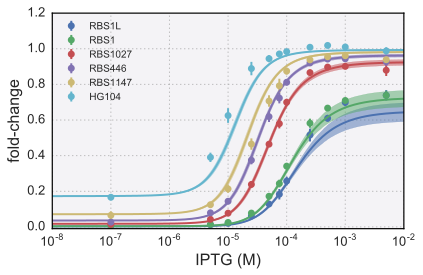

In [6]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_flatchain, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9)
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

## Testing the O2 RBS1027 fit on the O1 data

In [9]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O1_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df_O1 = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df_O1 = df_O1[(df_O1.rbs != 'auto') & (df_O1.rbs != 'delta')]

df_O1.head()

Number of unique data-sets: 2


date  username operator  binding_energy      rbs  repressors  IPTG_uM  \
2  20160819  nbellive       O1           -15.3    RBS1L         870      0.0   
3  20160819  nbellive       O1           -15.3     RBS1         610      0.0   
4  20160819  nbellive       O1           -15.3  RBS1027         130      0.0   
5  20160819  nbellive       O1           -15.3   RBS446          62      0.0   
6  20160819  nbellive       O1           -15.3  RBS1147          30      0.0   

    mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
2  3284.654178          47.038532       0.004017  
3  3175.688465         -61.927181      -0.005289  
4  3278.432719          40.817073       0.003486  
5  3237.250759          -0.364887      -0.000031  
6  3335.884241          98.268595       0.008393

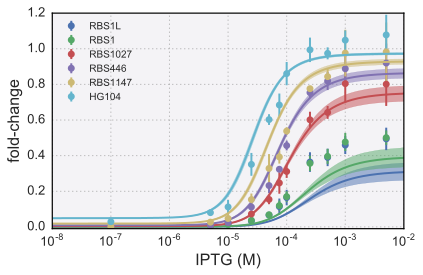

In [10]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df_O1.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1[(df_O1.rbs == rbs)].binding_energy.unique()),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_flatchain, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1.binding_energy.unique())
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df_O1[df_O1.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

### Running the MCMC with all the data except wild-type

Now it's time to run the MCMC using all of the strains but wild-type simultaneously.

In [18]:
# extracting independent and dependent variables
indep_var = df[df.rbs!='HG104'][['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df[df.rbs!='HG104'].fold_change_A

# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

In [19]:
# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(indep_var, dep_var, 4.5, ea_range, ei_range, sigma_range),\
                threads=6)

In [20]:
sample = True
if sample:
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_gauss_homoscedastic_pool_data.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

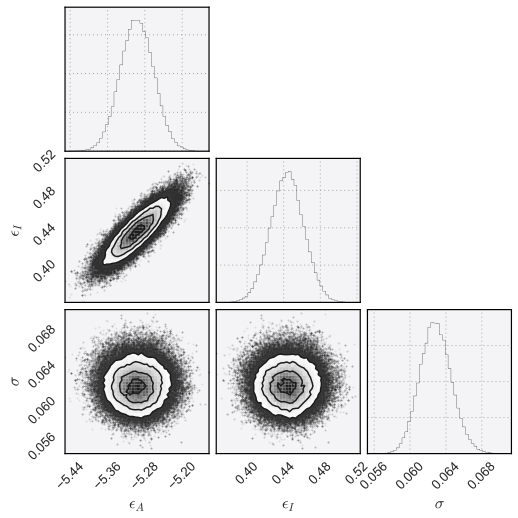

In [16]:
# read the flat-chain
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()

# plot the corner plot
fig = corner.corner(gauss_pool_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

In [3]:
# Load the data
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    
# map value of the parameters
ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)
Ka, Ki = np.exp(-ea), np.exp(-ei)
# ea range
ea_hpd = mwc.hpd(gauss_pool_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_pool_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.5f} +{4:0.6f} -{5:0.6f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 199.71 +14.291 -13.656 uM
Ki = 0.64156 +0.023435 -0.022241 uM



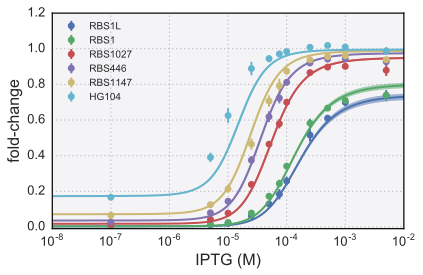

In [6]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_pool_flatchain, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9)
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

## Predicting other operators with these parameters.

We will extend these parameters to other operators since in principle once these parameters are fixed there are not unknowns left for the other parameters.

Let's start with O1

In [13]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O1_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df_O1 = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df_O1 = df_O1[(df_O1.rbs != 'auto') & (df_O1.rbs != 'delta')]

df_O1.head()

Number of unique data-sets: 2


date  username operator  binding_energy      rbs  repressors  IPTG_uM  \
2  20160819  nbellive       O1           -15.3    RBS1L         870      0.0   
3  20160819  nbellive       O1           -15.3     RBS1         610      0.0   
4  20160819  nbellive       O1           -15.3  RBS1027         130      0.0   
5  20160819  nbellive       O1           -15.3   RBS446          62      0.0   
6  20160819  nbellive       O1           -15.3  RBS1147          30      0.0   

    mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
2  3284.654178          47.038532       0.004017  
3  3175.688465         -61.927181      -0.005289  
4  3278.432719          40.817073       0.003486  
5  3237.250759          -0.364887      -0.000031  
6  3335.884241          98.268595       0.008393

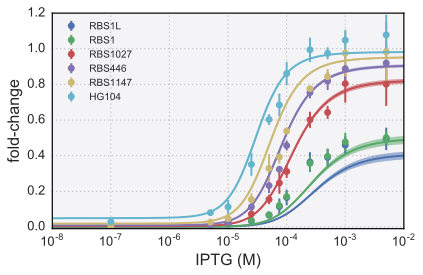

In [14]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df_O1.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1[(df_O1.rbs == rbs)].binding_energy.unique()),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_pool_flatchain, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1.binding_energy.unique())
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df_O1[df_O1.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

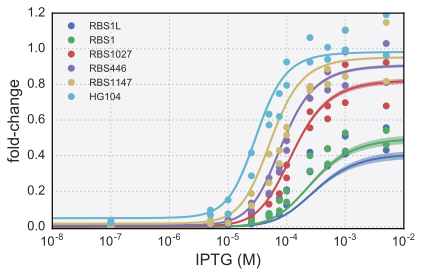

In [16]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df_O1.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1[(df_O1.rbs == rbs)].binding_energy.unique()),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_pool_flatchain, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1.binding_energy.unique())
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # plot the experimental data
    plt.plot(df_O1[df_O1.rbs == rbs].sort_values(by='IPTG_uM').IPTG_uM / 1E6, 
            df_O1[df_O1.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0, label=rbs, color=colors[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

# Second approach:
## Cauchy likelihood (for outliers)

A different approach to the problem is to consider that the residuals, i.e. the difference between our theoretical model and the data, have a Cauchy distribution rather than a Gaussian.

The difference in this approach is that the Cauchy distribution has very long tails compare to the Gaussian distribution. This allows "outliers to exist" but gives them a very small weight when performing the fitting. This is different to what the Gaussian likelihood would do where an outlier is such an incredibly rare event, that every data point that you see must be basically "real" and therefore tries to fit the model giving very similar weight to all the data points.

The assumptions of the model can again be listed as
1. each measurement is independent.
2. the errors are **Cauchy** distributed.
3. the error distribution is homoscedastic, i.e. this error is constant along the range of IPTG.

With this in hand we implement the first assumption as

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, \frac{c^{(i)}}{c_o}, I),
\end{equation}

where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \beta, I) = \frac{1}{\beta} \prod_{i = 1}^n \left[ \pi \beta \left(1 + \left( \frac{fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, \frac{c^{(i)}}{c_o} \right)}{\beta} \right)^2 \right) \right]^{-1}
\end{equation}

where we include the parameter $\beta$ associated with the Cauchy distribution.

We can again assume Jeffrey's priors for all 3 parameters and define again the log-likelihood to perform the MCMC run.

In [ ]:
def log_likelihood_cauchy(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the Cauchy log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = beta. scale parameter which specifies the half-width 
                   at half-maximum.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the Cauchy log likelihood.
    """
    # unpack parameters
    ea, ei, beta = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r)
   
    log_like = np.sum(np.log(1 + ((fc_theory - dep_var) / beta)**2))
    return log_like

def log_post_cauchy(param, indep_var, dep_var, epsilon=4.5,
                    ea_range=[6 -6], ei_range=[6, -6]):
    '''
    Computes the log posterior probability for a Cauchy likelihood.
    Parameters
    ----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = beta. scale parameter which specifies the half-width 
                   at half-maximum.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    ea, ei, beta = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ea < np.min(ei_range)\
    or beta <= 0:
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(beta) \
           - log_likelihood_cauchy(param, indep_var, dep_var, epsilon)


Having written the functions let's test them!

In [ ]:
rbs = df[df.rbs=='RBS1027']
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(rbs, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.exponential(1.0, n_walkers)

In [ ]:
#Call the sampler. 
sampler_cauchy = emcee.EnsembleSampler(n_walkers, n_dim, log_post_cauchy,\
                 args=(indep_var, dep_var, 4.5),\
                 threads=6)

In [ ]:
#Do the burn in 
pos, prob, state = sampler_cauchy.run_mcmc(p0, n_burn, storechain=False)

In [ ]:
# Perform the real MCMC
_ = sampler_cauchy.run_mcmc(pos, n_steps)

### Cauchy likelihood, homoscedastic error

In [ ]:
fig = corner.corner(sampler_cauchy.flatchain, bins=50, plot_contours=True,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\beta$'])